## Imports


In [1]:
import pandas as pd
import numpy as np
from keras import metrics
from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense, Concatenate, BatchNormalization, LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## Data Pre-Processing

In [2]:
# Load and combine data
PATH_TO_FILE_1 = "../raw data/aapl_2016_2020.csv"
PATH_TO_FILE_2 = "../raw data/aapl_2021_2023.csv"
half_1 = pd.read_csv(PATH_TO_FILE_1, low_memory=False)
half_2 = pd.read_csv(PATH_TO_FILE_2, low_memory=False)
df = pd.concat([half_1, half_2], ignore_index=True)
df.columns = df.columns.str.strip()

def cleaned_options(option_type, df):
    # Convert Unix timestamps to datetime
    df['[QUOTE_DATETIME]'] = pd.to_datetime(df['[QUOTE_UNIXTIME]'], unit='s')
    df['EXPIRE_DATETIME'] = pd.to_datetime(df['[EXPIRE_UNIX]'], unit='s')

    # Load underlying price data for volatility computation
    underlying_prices = df[['[QUOTE_DATETIME]', '[UNDERLYING_LAST]']].drop_duplicates().set_index('[QUOTE_DATETIME]').sort_index()

    # Function to compute historical volatility
    def historical_volatility(series, window=20):
        return np.sqrt(252) * series.pct_change().rolling(window=window).std()

    # Compute 20-day historical volatility
    underlying_prices['hist_vol_20d'] = historical_volatility(underlying_prices['[UNDERLYING_LAST]'])
    underlying_prices.dropna(inplace=True)

    # Merge historical volatility back into main dataframe
    df = df.merge(underlying_prices[['hist_vol_20d']], left_on='[QUOTE_DATETIME]', right_index=True, how='inner')

    # Columns to numeric conversion: choose columns based on option type
    if option_type == 'call':
        numeric_cols = ['[QUOTE_DATETIME]', '[UNDERLYING_LAST]', '[DTE]', '[STRIKE]', '[C_DELTA]', '[C_GAMMA]', '[C_VEGA]',
                        '[C_THETA]', '[C_RHO]', '[C_BID]', '[C_ASK]']
    else:
        numeric_cols = ['[QUOTE_DATETIME]', '[UNDERLYING_LAST]', '[DTE]', '[STRIKE]', '[P_DELTA]', '[P_GAMMA]', '[P_VEGA]',
                        '[P_THETA]', '[P_RHO]', '[P_BID]', '[P_ASK]']

    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

    # Calculate mid-price based on option type
    if option_type == 'call':
        df['CALL_EQUI_PRICE'] = (df['[C_BID]'] + df['[C_ASK]']) / 2
    else:
        df['PUT_EQUI_PRICE'] = (df['[P_BID]'] + df['[P_ASK]']) / 2

    # Drop rows with missing essential data (dynamically chosen based on option type)
    essential_cols = ['[QUOTE_DATETIME]', '[UNDERLYING_LAST]', '[DTE]', '[STRIKE]', 'hist_vol_20d']
    if option_type == 'call':
        essential_cols.append('CALL_EQUI_PRICE')
    else:
        essential_cols.append('PUT_EQUI_PRICE')
    df.dropna(subset=essential_cols, inplace=True)

    # Prepare option data based on the option type
    if option_type == 'call':
        option_cols = ['[STRIKE]', '[C_BID]', '[C_ASK]', '[QUOTE_DATETIME]', '[UNDERLYING_LAST]', '[DTE]', 'hist_vol_20d', 'CALL_EQUI_PRICE']
        col_rename = ['strike_price', 'best_bid', 'best_ask', 'date', 'underlying_price', 'days_to_expiry', 'hist_volatility', 'equilibrium_price']
    else:
        option_cols = ['[STRIKE]', '[P_BID]', '[P_ASK]', '[QUOTE_DATETIME]', '[UNDERLYING_LAST]', '[DTE]', 'hist_vol_20d', 'PUT_EQUI_PRICE']
        col_rename = ['strike_price', 'best_bid', 'best_ask', 'date', 'underlying_price', 'days_to_expiry', 'hist_volatility', 'equilibrium_price']

    option_df = df[option_cols].copy()
    option_df.columns = col_rename

    # Normalize strike price and compute time to expiry in years
    option_df['strike_price'] = option_df['strike_price'] / 1000
    option_df['time_to_expiry'] = option_df['days_to_expiry'] / 365
    option_df.drop('days_to_expiry', axis=1, inplace=True)
    return option_df

calls_df = cleaned_options("call", df)
puts_df = cleaned_options("put", df)
print(calls_df.columns.tolist())
print(puts_df.columns.tolist())

['strike_price', 'best_bid', 'best_ask', 'date', 'underlying_price', 'hist_volatility', 'equilibrium_price', 'time_to_expiry']
['strike_price', 'best_bid', 'best_ask', 'date', 'underlying_price', 'hist_volatility', 'equilibrium_price', 'time_to_expiry']


## Underlying Processing

In [3]:
# 1) For calls
calls_close_df = (
    calls_df[['date', 'underlying_price']]
    .drop_duplicates()
    .rename(columns={'underlying_price': 'close'})
    .sort_values('date')
    .reset_index(drop=True)
)

# 2) For puts
puts_close_df = (
    puts_df[['date', 'underlying_price']]
    .drop_duplicates()
    .rename(columns={'underlying_price': 'close'})
    .sort_values('date')
    .reset_index(drop=True)
)

combined_df = pd.concat([calls_close_df, puts_close_df], ignore_index=True)
underlying = (
    puts_df[['date', 'underlying_price']]
    .drop_duplicates()
    .rename(columns={'underlying_price': 'close'})
    .sort_values('date')
    .reset_index(drop=True)
)

## Hyperparameters

In [4]:
N_TIMESTEPS = 20
BATCH_SIZE = 4096
EPOCHS = 300

## Prepare Test Split

In [5]:
padded = np.insert(underlying.close.values, 0, np.array([np.nan] * N_TIMESTEPS))
rolled = np.column_stack([np.roll(padded, i) for i in range(N_TIMESTEPS)])
rolled = rolled[~np.isnan(rolled).any(axis=1)]
rolled = np.column_stack((underlying.date.values[N_TIMESTEPS - 1:], rolled))
price_history = pd.DataFrame(data=rolled)
price_history.columns = ['date'] + [f"lag_{i}" for i in range(N_TIMESTEPS)]

calls_df, puts_df = calls_df.merge(price_history, on='date', how='inner'), puts_df.merge(price_history, on='date', how='inner')
calls_df, puts_df, = calls_df.drop(columns=['date']), puts_df.drop(columns=['date'])

X_call_train, X_call_test, y_call_train, y_call_test = train_test_split(calls_df.drop(['best_bid', 'best_ask'], axis=1).values,
                                                                        ((calls_df.best_bid + calls_df.best_ask) / 2).values,
                                                                        test_size=0.01, random_state=42)

X_put_train, X_put_test, y_put_train, y_put_test = train_test_split(puts_df.drop(['best_bid', 'best_ask'], axis=1).values,
                                                                    ((puts_df.best_bid + puts_df.best_ask) / 2).values,
                                                                    test_size=0.01, random_state=42)

call_X_train = [X_call_train[:, -N_TIMESTEPS:].reshape(X_call_train.shape[0], N_TIMESTEPS, 1), X_call_train[:, :4]]
call_X_test = [X_call_test[:, -N_TIMESTEPS:].reshape(X_call_test.shape[0], N_TIMESTEPS, 1), X_call_test[:, :4]]
put_X_train = [X_put_train[:, -N_TIMESTEPS:].reshape(X_put_train.shape[0], N_TIMESTEPS, 1), X_put_train[:, :4]]
put_X_test = [X_put_test[:, -N_TIMESTEPS:].reshape(X_put_test.shape[0], N_TIMESTEPS, 1), X_put_test[:, :4]]

## Scaling

In [6]:
# Create separate scalers for calls and puts
scaler_calls = StandardScaler()
scaler_puts = StandardScaler()

# Scale call X data
X_call_train_scaled = scaler_calls.fit_transform(X_call_train)
X_call_test_scaled = scaler_calls.transform(X_call_test)

# Scale put X data
X_put_train_scaled = scaler_puts.fit_transform(X_put_train)
X_put_test_scaled = scaler_puts.transform(X_put_test)

# Reshape the last N_TIMESTEPS columns for LSTM
call_X_train_scaled = [
    X_call_train_scaled[:, -N_TIMESTEPS:].reshape(X_call_train_scaled.shape[0], N_TIMESTEPS, 1),
    X_call_train_scaled[:, :4]
]
call_X_test_scaled = [
    X_call_test_scaled[:, -N_TIMESTEPS:].reshape(X_call_test_scaled.shape[0], N_TIMESTEPS, 1),
    X_call_test_scaled[:, :4]
]

put_X_train_scaled = [
    X_put_train_scaled[:, -N_TIMESTEPS:].reshape(X_put_train_scaled.shape[0], N_TIMESTEPS, 1),
    X_put_train_scaled[:, :4]
]
put_X_test_scaled = [
    X_put_test_scaled[:, -N_TIMESTEPS:].reshape(X_put_test_scaled.shape[0], N_TIMESTEPS, 1),
    X_put_test_scaled[:, :4]
]

## LSTM Model

In [7]:
def create_multi_input_model(
    n_timesteps=20,
    n_lstm_features=1, # each timestep has 1 feature: 'lag' value
    n_static_features=7,
    lstm_units=32,
    dense_layers=2,
    dense_units=64
):
    # Time series input
    time_input = Input(shape=(n_timesteps, n_lstm_features), name="time_input")
    x = LSTM(lstm_units, return_sequences=True)(time_input)
    x = LSTM(lstm_units, return_sequences=True)(x)
    x = LSTM(lstm_units, return_sequences=True)(x)
    x = LSTM(lstm_units, return_sequences=False)(x)

    for _ in range(dense_layers):
        x = Dense(dense_units)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)

    # Static input
    static_input = Input(shape=(n_static_features,), name="static_input")
    
    # Concatenate both
    combined = Concatenate()([x, static_input])
    
    for _ in range(dense_layers):
        combined = Dense(dense_units)(combined)
        combined = BatchNormalization()(combined)
        combined = LeakyReLU()(combined)
    
    output = Dense(1, activation='relu', name="price_output")(combined)

    model = Model(inputs=[time_input, static_input], outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=1e-8,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

## Training for Calls

In [ ]:
N = X_call_train.shape[0]

# The first 5 columns = static features
X_call_train_static = X_call_train[:, :5]  # shape => (N, 5)

# The last 20 columns = time series
X_call_train_lstm   = X_call_train[:, 5:].reshape(N, 20, 1)  # shape => (N, 20, 1)

N_test = X_call_test.shape[0]
X_call_test_static = X_call_test[:, :5]
X_call_test_lstm   = X_call_test[:, 5:].reshape(N_test, 20, 1)

call_model = create_multi_input_model(
    n_timesteps=N_TIMESTEPS,
    n_lstm_features=1,
    n_static_features=5,
    lstm_units=32,
    dense_layers=2,
    dense_units=64
)
call_model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')

call_history = call_model.fit(
    x=[X_call_train_lstm, X_call_train_static],
    y=y_call_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
    callbacks=[reduce_lr, early_stop, TensorBoard(log_dir='./logs')],
    verbose=1
)

call_model.save('call-lstm-v1.h5')

Epoch 1/300
335/335 ━━━━━━━━━━━━━━━━━━━━ 83s 232ms/step - loss: 3267.3538 - val_loss: 2731.1191 - learning_rate: 1.0000e-04
Epoch 2/300
335/335 ━━━━━━━━━━━━━━━━━━━━ 77s 230ms/step - loss: 2727.7368 - val_loss: 2562.3667 - learning_rate: 1.0000e-04
Epoch 3/300
335/335 ━━━━━━━━━━━━━━━━━━━━ 77s 229ms/step - loss: 2507.7747 - val_loss: 2370.2603 - learning_rate: 1.0000e-04
Epoch 4/300
335/335 ━━━━━━━━━━━━━━━━━━━━ 77s 231ms/step - loss: 2310.3469 - val_loss: 2147.6345 - learning_rate: 1.0000e-04
Epoch 5/300
335/335 ━━━━━━━━━━━━━━━━━━━━ 78s 232ms/step - loss: 2111.6521 - val_loss: 1947.4851 - learning_rate: 1.0000e-04
Epoch 6/300
335/335 ━━━━━━━━━━━━━━━━━━━━ 76s 228ms/step - loss: 1883.8413 - val_loss: 1756.7643 - learning_rate: 1.0000e-04
Epoch 7/300
335/335 ━━━━━━━━━━━━━━━━━━━━ 77s 230ms/step - loss: 1692.1501 - val_loss: 1561.5669 - learning_rate: 1.0000e-04
Epoch 8/300
335/335 ━━━━━━━━━━━━━━━━━━━━ 77s 228ms/step - loss: 1495.8901 - val_loss: 1357.1615 - learning_rate: 1.0000e-04
Epoch 9/

## Training for Puts

In [ ]:
N_put_train = X_put_train.shape[0]

# The first 5 columns = static features
X_put_train_static = X_put_train[:, :5]  # shape => (N_put_train, 5)

# The last 20 columns = time series
X_put_train_lstm   = X_put_train[:, 5:].reshape(N_put_train, 20, 1)  # shape => (N_put_train, 20, 1)

N_put_test = X_put_test.shape[0]
X_put_test_static = X_put_test[:, :5]
X_put_test_lstm   = X_put_test[:, 5:].reshape(N_put_test, 20, 1)

put_model = create_multi_input_model(
    n_timesteps=20,
    n_lstm_features=1,
    n_static_features=5,
    lstm_units=32,
    dense_layers=2,
    dense_units=64
)
put_model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')

put_history = put_model.fit(
    x=[X_put_train_lstm, X_put_train_static],
    y=y_put_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
    callbacks=[reduce_lr, early_stop, TensorBoard(log_dir='./logs')],
    verbose=1
)

put_model.save('put-lstm-v1.h5')

Epoch 1/300
335/335 ━━━━━━━━━━━━━━━━━━━━ 77s 213ms/step - loss: 2012.0024 - val_loss: 1682.0160 - learning_rate: 1.0000e-04
Epoch 2/300
335/335 ━━━━━━━━━━━━━━━━━━━━ 75s 225ms/step - loss: 1598.0482 - val_loss: 1461.6913 - learning_rate: 1.0000e-04
Epoch 3/300
335/335 ━━━━━━━━━━━━━━━━━━━━ 77s 231ms/step - loss: 1441.8267 - val_loss: 1281.8242 - learning_rate: 1.0000e-04
Epoch 4/300
335/335 ━━━━━━━━━━━━━━━━━━━━ 78s 231ms/step - loss: 1291.5509 - val_loss: 1160.5125 - learning_rate: 1.0000e-04
Epoch 5/300
335/335 ━━━━━━━━━━━━━━━━━━━━ 78s 233ms/step - loss: 1149.1742 - val_loss: 1027.5371 - learning_rate: 1.0000e-04
Epoch 6/300
335/335 ━━━━━━━━━━━━━━━━━━━━ 79s 234ms/step - loss: 1001.6137 - val_loss: 902.2968 - learning_rate: 1.0000e-04
Epoch 7/300
335/335 ━━━━━━━━━━━━━━━━━━━━ 78s 232ms/step - loss: 863.9401 - val_loss: 759.9935 - learning_rate: 1.0000e-04
Epoch 8/300
335/335 ━━━━━━━━━━━━━━━━━━━━ 78s 234ms/step - loss: 728.9940 - val_loss: 610.7250 - learning_rate: 1.0000e-04
Epoch 9/300
3

## Test Models

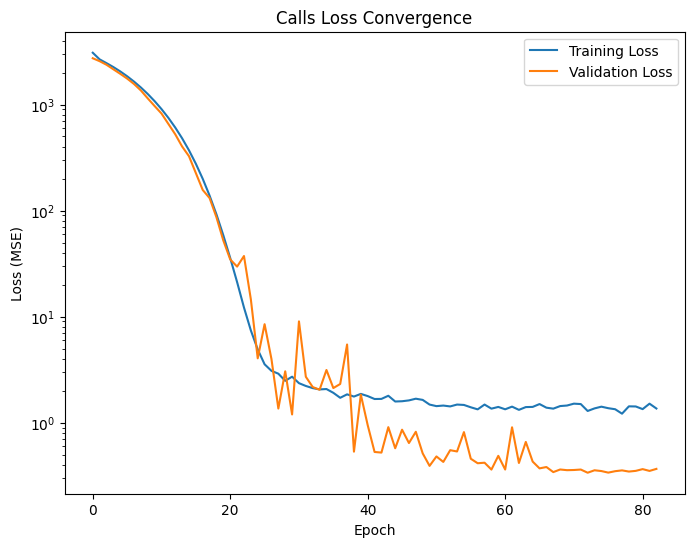

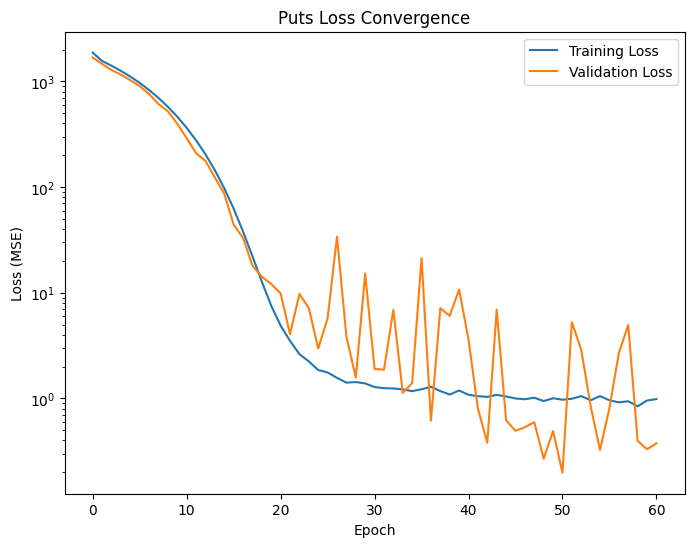

In [ ]:
def plot_loss_convergence(history, title):
    """
    Plots training vs validation loss over epochs with log scale on y-axis.
    """
    plt.figure(figsize=(8,6))
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    plt.yscale('log')
    plt.legend()
    plt.show()

plot_loss_convergence(call_history, "Calls Loss Convergence")
plot_loss_convergence(put_history, "Puts Loss Convergence")

## Test Call Predictions

In [9]:
loaded_model = load_model('call-lstm-v1.h5', custom_objects={'mse': metrics.mean_squared_error})
sample_entries = pd.DataFrame(X_call_test).sample(10)
features_vector = pd.DataFrame(sample_entries).iloc[:, 5:].values.reshape(-1, 20, 1) 
prices_sequence = pd.DataFrame(sample_entries).iloc[:, :5].values
predictions = loaded_model.predict([features_vector, prices_sequence])

for i, idx in enumerate(sample_entries.index):
    actual_price = pd.DataFrame(y_call_test).loc[idx].values[0]
    print(f"Entry {idx} - Predicted price: {predictions[i][0]:.2f}, Actual price: {actual_price:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
Entry 904 - Predicted price: 0.00, Actual price: 0.04
Entry 7050 - Predicted price: 12.89, Actual price: 13.10
Entry 2077 - Predicted price: 0.00, Actual price: 1.40
Entry 11118 - Predicted price: 0.00, Actual price: 0.28
Entry 13805 - Predicted price: 0.00, Actual price: 0.01
Entry 833 - Predicted price: 23.43, Actual price: 23.33
Entry 4183 - Predicted price: 47.66, Actual price: 47.37
Entry 4520 - Predicted price: 110.63, Actual price: 110.38
Entry 2732 - Predicted price: 4.62, Actual price: 4.45
Entry 1031 - Predicted price: 14.89, Actual price: 14.75


## Test Puts Predictions

In [10]:
loaded_model = load_model('put-lstm-v1.h5', custom_objects={'mse': metrics.mean_squared_error})
sample_entries = pd.DataFrame(X_put_test).sample(10)
features_vector = pd.DataFrame(sample_entries).iloc[:, 5:].values.reshape(-1, 20, 1)
prices_sequence = pd.DataFrame(sample_entries).iloc[:, :5].values
predictions = loaded_model.predict([features_vector, prices_sequence])

for i, idx in enumerate(sample_entries.index):
    actual_price = pd.DataFrame(y_put_test).loc[idx].values[0]
    print(f"Entry {idx} - Predicted price: {predictions[i][0]:.2f}, Actual price: {actual_price:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
Entry 6969 - Predicted price: 47.74, Actual price: 47.52
Entry 14232 - Predicted price: 50.43, Actual price: 50.55
Entry 110 - Predicted price: 0.00, Actual price: 0.38
Entry 11642 - Predicted price: 131.29, Actual price: 131.57
Entry 14982 - Predicted price: 109.79, Actual price: 110.55
Entry 3722 - Predicted price: 41.82, Actual price: 41.95
Entry 5046 - Predicted price: 13.74, Actual price: 13.74
Entry 3294 - Predicted price: 34.67, Actual price: 34.80
Entry 8673 - Predicted price: 84.63, Actual price: 84.97
Entry 1536 - Predicted price: 0.00, Actual price: 0.35


481/481 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step

--- Call LSTM Error Metrics ---
MAE: 0.3119
RMSE: 0.5851
MAPE: nan%
R² Score: 0.9998
Mean Error: -0.1701
Std Deviation: 0.5599
Max Error: 1.3700
Min Error: -3.6000


C:\Users\Adam Khalil\AppData\Local\Temp\ipykernel_4476\2886782018.py:15: RuntimeWarning: invalid value encountered in divide
  percent_error = 100 * diff / y_true


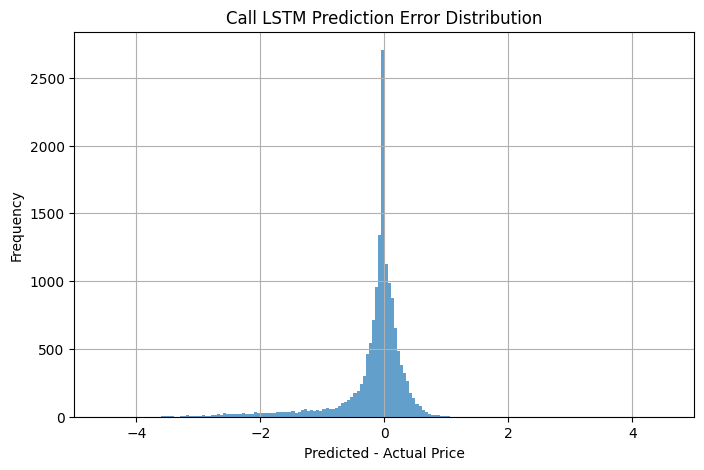

481/481 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

--- Put LSTM Error Metrics ---
MAE: 0.2893
RMSE: 0.4545
MAPE: nan%
R² Score: 0.9999
Mean Error: -0.1481
Std Deviation: 0.4297
Max Error: 1.0194
Min Error: -2.4850


C:\Users\Adam Khalil\AppData\Local\Temp\ipykernel_4476\2886782018.py:15: RuntimeWarning: invalid value encountered in divide
  percent_error = 100 * diff / y_true


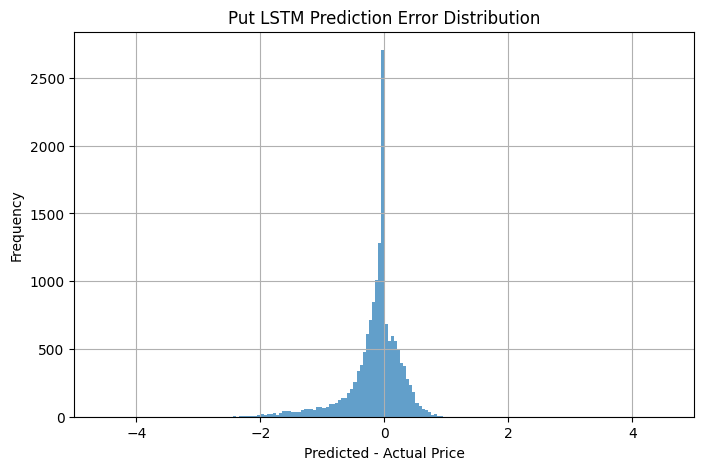

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def full_lstm_error_analysis(X_test, y_test, model_path, label):
    model = load_model(model_path, custom_objects={'mse': metrics.mean_squared_error})
    
    X_df = pd.DataFrame(X_test)
    y_true = pd.DataFrame(y_test).values.flatten()

    features_vector = X_df.iloc[:, 5:].values.reshape(-1, 20, 1)
    prices_sequence = X_df.iloc[:, :5].values

    predictions = model.predict([features_vector, prices_sequence]).flatten()
    diff = predictions - y_true
    abs_error = np.abs(diff)
    percent_error = 100 * diff / y_true
    abs_percent_error = np.abs(percent_error)

    # Metrics
    mae = mean_absolute_error(y_true, predictions)
    rmse = np.sqrt(mean_squared_error(y_true, predictions))
    mape = abs_percent_error.mean()
    r2 = r2_score(y_true, predictions)

    print(f"\n--- {label} LSTM Error Metrics ---")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R² Score: {r2:.4f}")
    print(f"Mean Error: {diff.mean():.4f}")
    print(f"Std Deviation: {diff.std():.4f}")
    print(f"Max Error: {diff.max():.4f}")
    print(f"Min Error: {diff.min():.4f}")

    # Histogram
    plt.figure(figsize=(8, 5))
    plt.hist(diff, bins=np.arange(-5, 5, 0.05), alpha=0.7)
    plt.title(f"{label} LSTM Prediction Error Distribution")
    plt.xlabel("Error (Predicted - Actual)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.xlim([-5, 5])
    plt.show()

# Run error analysis
full_lstm_error_analysis(X_call_test, y_call_test, 'call-lstm-v1.h5', label='Call')
full_lstm_error_analysis(X_put_test, y_put_test, 'put-lstm-v1.h5', label='Put')